<a href="https://colab.research.google.com/github/Untick/IrisID_gr1/blob/Aigul-Jakypakunova-folder/Aigul%20Jakypakunova/%D0%97%D0%B5%D0%BD%D0%B8%D1%86%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Работа с массивами
import numpy as np

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных из облака
import gdown

# Инструменты для работы с файлами
import os

# Для работы с архивами
import zipfile

# Отрисовка графиков
import matplotlib.pyplot as plt

# Рисование графиков в ячейках Colab
%matplotlib inline
     
import time 

# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
from google.colab import drive
drive.mount('/content/drive')

In [110]:

# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
gdown.download
import gdown 

# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
gdown.download('https://drive.google.com/uc?id=1-cVSZZ-qzSIBpxZRR5QcaUsotGFQY3Wh', None, quiet=True)

'Iris_ID.zip'

In [113]:
TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/iris'           # Папка для обучающего набора данных
TEST_PATH  = '/content/drive/MyDrive/Colab Notebooks/test'  # Папка для тестового набора данных

TEST_SPLIT          = 0.2                 # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 192                   # Ширина изображения для нейросети
IMG_HEIGHT          = 144                   # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = False                 # Горизонтальное отражение разрешено

EPOCHS              = 100                  # Число эпох обучения
BATCH_SIZE          = 8                     # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0001)          # Оптимизатор

In [112]:
# Разархивация датасета в директорию 'content/'
!unzip -qo "Iris_ID.zip" -d /content/

# Путь к архиву Iris_ID.zip
zip_path = '/content/Iris_ID.zip'
# Путь к директории, в которую нужно распаковать архивы
extract_path = TRAIN_PATH
TRAIN_PATH='/content/drive/MyDrive/Colab Notebooks/iris'

extract_path = TEST_PATH
TEST_PATH='/content/drive/MyDrive/Colab Notebooks/test'

# Создаем директорию, если ее нет
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

from zipfile import *



# Открываем архив Iris_ID.zip
with zipfile.ZipFile(zip_path, 'r') as main_zip:
    # Итерируемся по всем архивам внутри Iris_ID.zip
    for archive_name in main_zip.namelist():
        # Если архив - iris1_*zip, то распаковываем его
        # print(archive_name)
        if 'iris' in archive_name:
            with main_zip.open(archive_name) as archive_file:
                with zipfile.ZipFile(archive_file, 'r') as archive:
                    # Извлекаем все файлы из архива в директорию extract_path
                    archive.extractall(path=extract_path)
                    
                    # Создаем папки для каждого класса и перемещаем файлы в соответствующую папку
                    for i in range(1, 65):
                        class_folder = os.path.join(extract_path, f'{i:03}')
                        if not os.path.exists(class_folder):
                            os.makedirs(class_folder)
                        for file_name in ['%03dL_%d.png' % (i, j) for j in range(1, 4)] + ['%03dR_%d.png' % (i, j) for j in range(1, 4)]:
                            file_path = os.path.join(extract_path, file_name)
                            if os.path.exists(file_path):
                                os.replace(file_path, os.path.join(class_folder, file_name))
# Очистка данных от прошлого запуска (если есть)
!rm -rf {TRAIN_PATH} {TEST_PATH}



     

In [114]:

# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 64, метки классов: ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064']


In [115]:

# Создание директории тестовых данных
os.mkdir(TEST_PATH)                                        
train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса
    os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} фото, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')
     

FileExistsError: ignored

In [116]:


# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

In [ ]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 320 images belonging to 64 classes.
Found 64 images belonging to 64 classes.
Found 384 images belonging to 64 classes.


In [117]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (8, 144, 192, 3), (8, 64), батчей: 40
Формы данных   проверочной выборки: (8, 144, 192, 3), (8, 64), батчей: 8


ZeroDivisionError: ignored

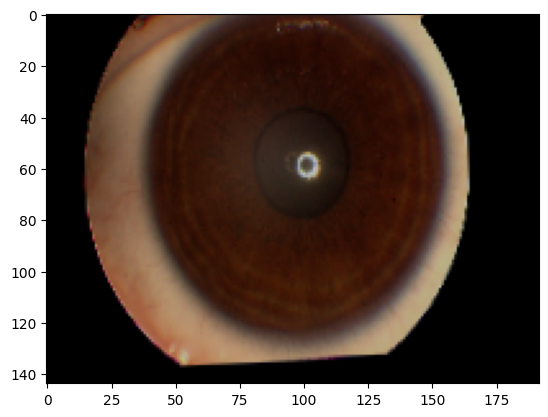

In [118]:
# Проверка одного изображения из выборки
plt.imshow(train_generator[1][0][2])
plt.show()

In [ ]:
# Картинка в виде трехмерного массива нормализованных пикселей (от 0 до 1):
train_generator[1][0][2]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [119]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(7),   # диапазон номеров картинок
               figsize=(24, 7),      # размер полотна для рисования одной строки таблицы
               columns=4             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])  
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

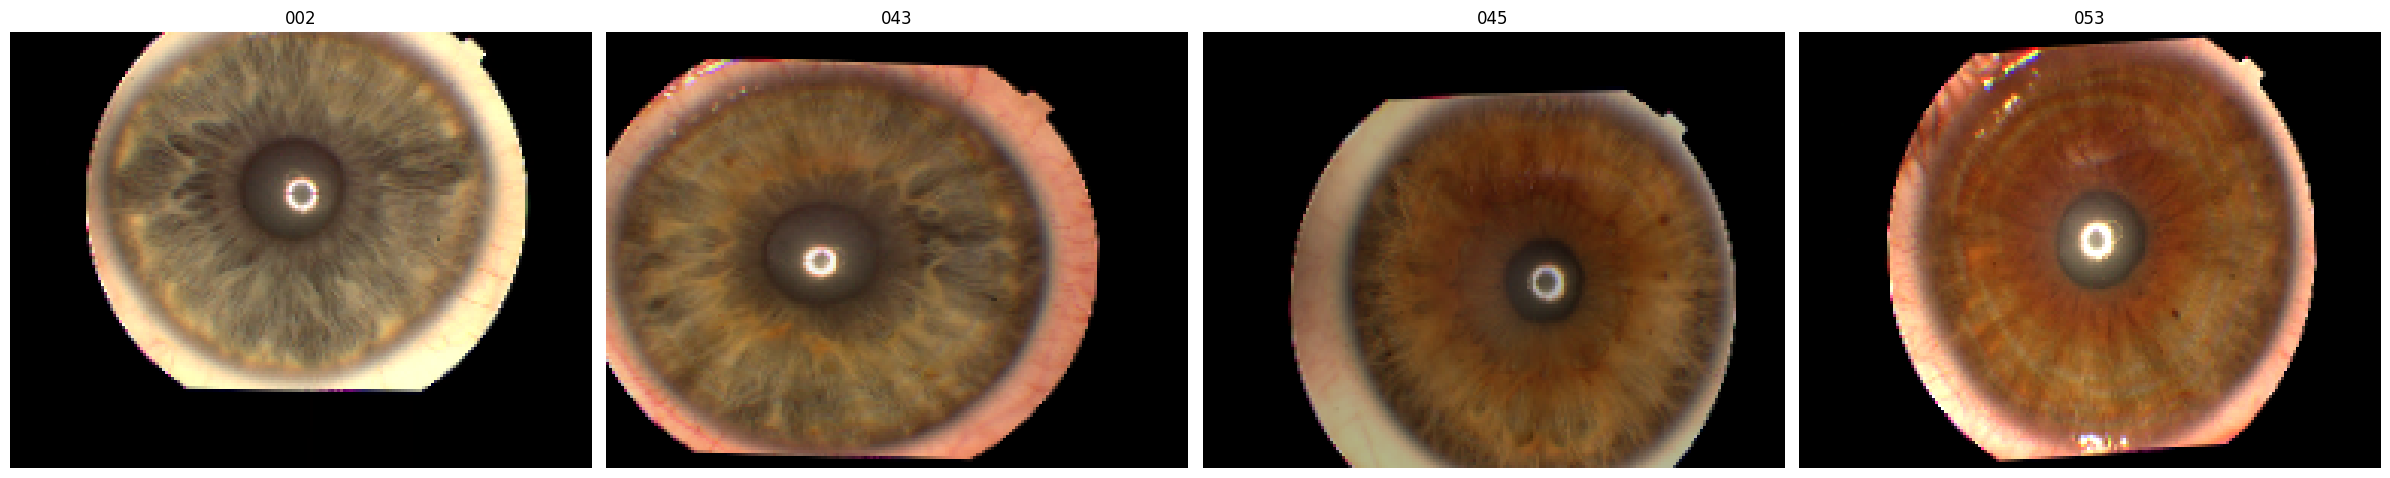

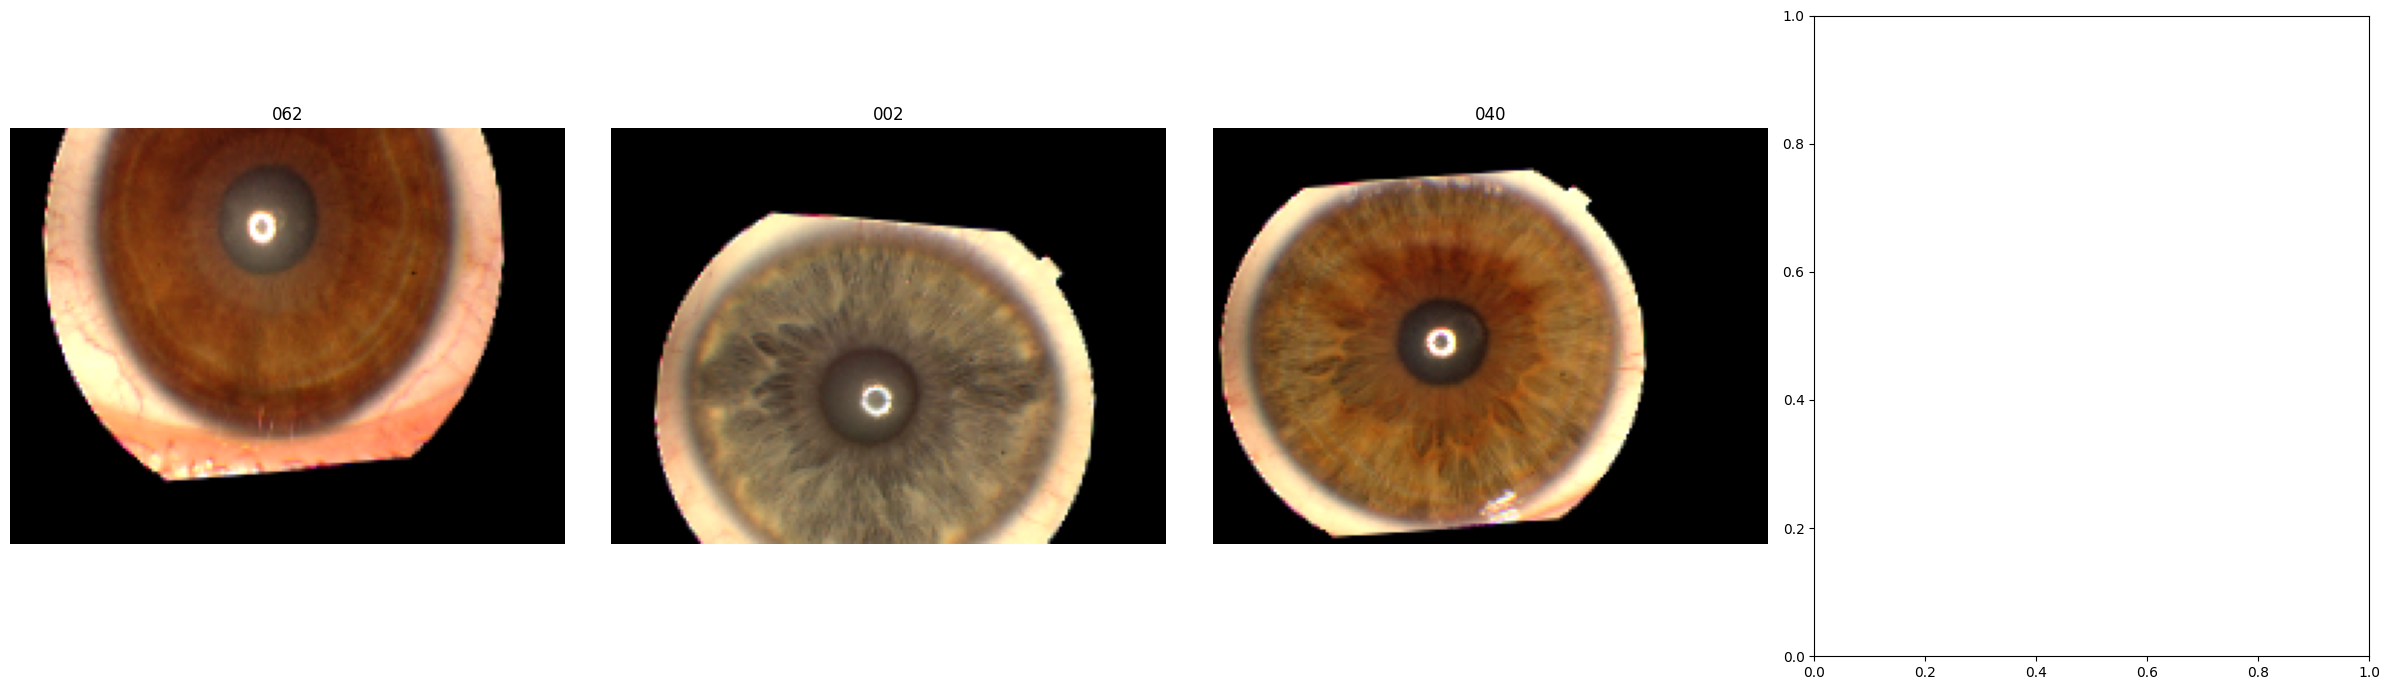

In [120]:

# Вывод примеров из 0-го батча train_generator
show_batch(train_generator[0])

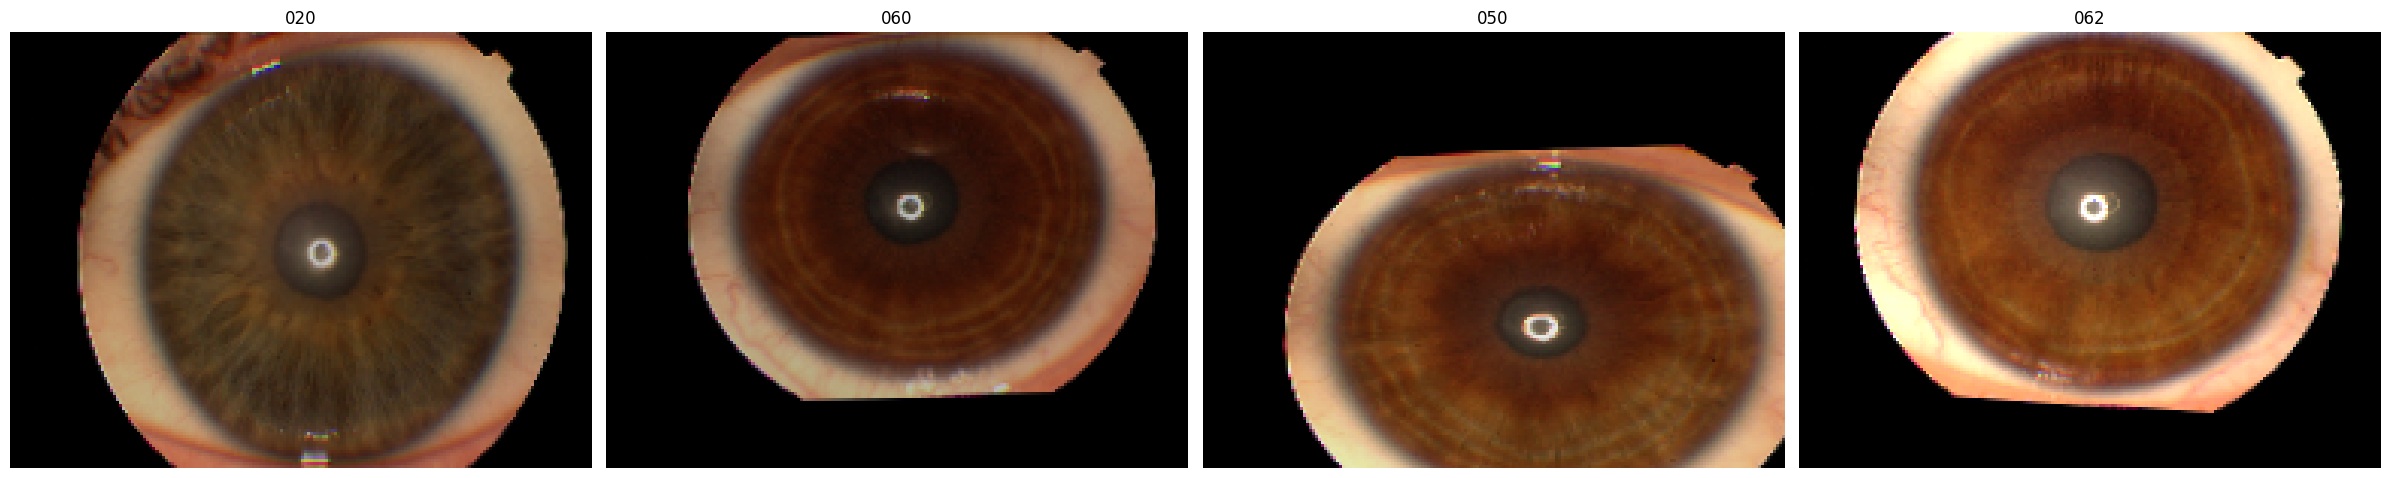

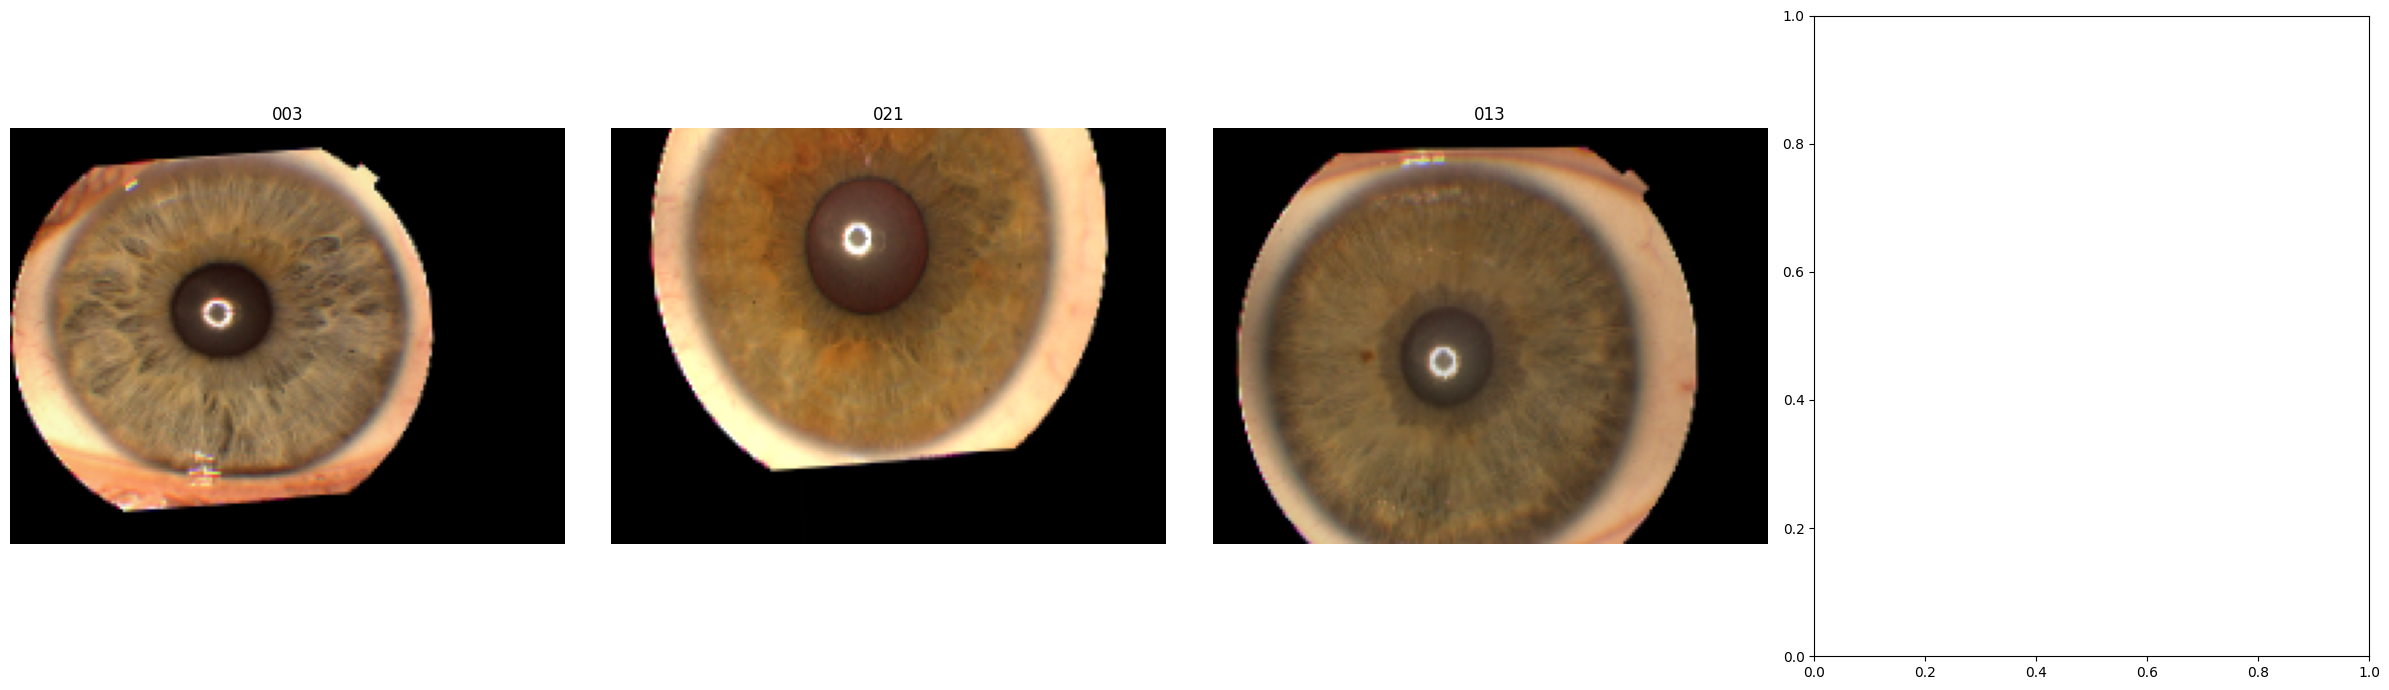

In [121]:

# Вывод примеров из 0-го батча validation_generator
show_batch(validation_generator[0])

In [122]:

# Вывод примеров из 0-го (единственного) батча test_generator
show_batch(test_generator[0])

ZeroDivisionError: ignored

In [123]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Вывод сводки
    # model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

In [124]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model, 
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))
     

In [125]:
# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model, 
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1], 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size)

In [126]:
model = Sequential()

# Сверточные слои
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Полносвязные слои
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASS_COUNT, activation='softmax'))

model.summary()
     

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 144, 192, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 144, 192, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 72, 96, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 72, 96, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 72, 96, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 96, 64)        36928     
                                                      

Epoch 1/100
40/40 [==============================] - 101s 2s/step - loss: 4.2008 - accuracy: 0.0125 - val_loss: 4.1596 - val_accuracy: 0.0000e+00
Epoch 2/100
40/40 [==============================] - 94s 2s/step - loss: 4.1597 - accuracy: 0.0094 - val_loss: 4.1585 - val_accuracy: 0.0156
Epoch 3/100
40/40 [==============================] - 94s 2s/step - loss: 4.1601 - accuracy: 0.0063 - val_loss: 4.1582 - val_accuracy: 0.0469
Epoch 4/100
40/40 [==============================] - 94s 2s/step - loss: 4.1579 - accuracy: 0.0125 - val_loss: 4.1575 - val_accuracy: 0.0156
Epoch 5/100
40/40 [==============================] - 94s 2s/step - loss: 4.1562 - accuracy: 0.0125 - val_loss: 4.1546 - val_accuracy: 0.0156
Epoch 6/100
40/40 [==============================] - 103s 3s/step - loss: 4.1476 - accuracy: 0.0156 - val_loss: 4.1425 - val_accuracy: 0.0156
Epoch 7/100
40/40 [==============================] - 101s 3s/step - loss: 4.1255 - accuracy: 0.0156 - val_loss: 4.0399 - val_accuracy: 0.0469
Epoch 

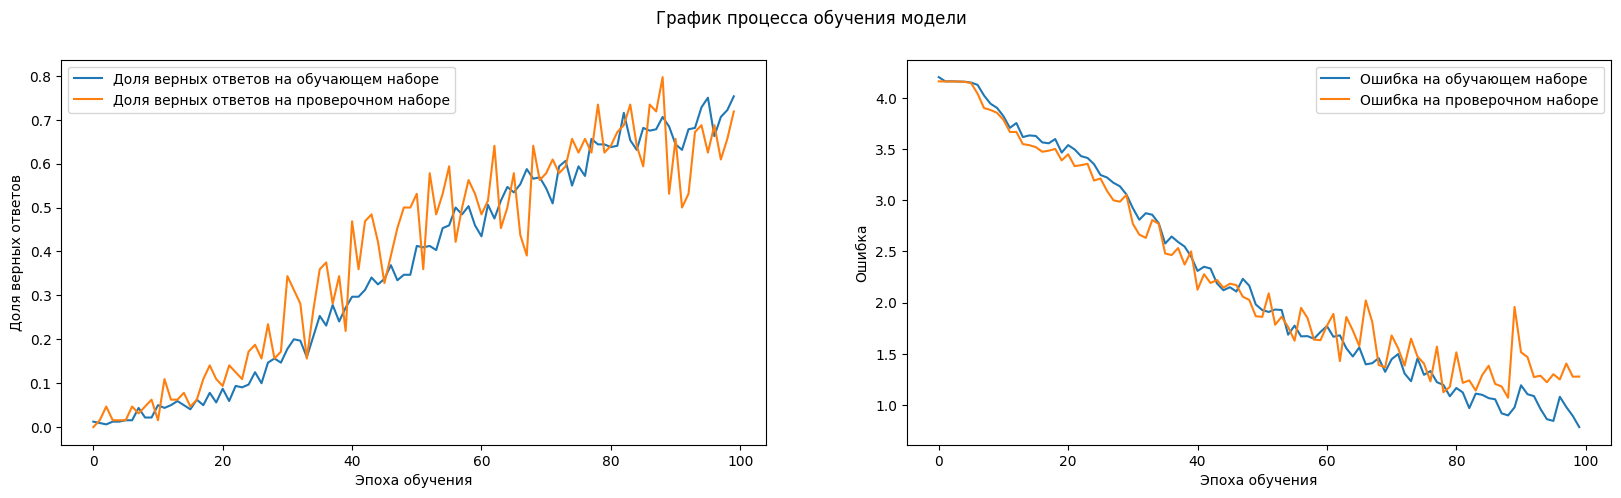

ZeroDivisionError: ignored

In [127]:

# Обучение модели и вывод оценки ее работы на тестовых данных
compile_train_eval_model(model,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Сверточный классификатор')